In [5]:
import logging
import math
import os

logging.basicConfig(level=logging.INFO)
logging.info("library loading")
logging.info("DEBUG")

import torch
import librosa

torch.set_grad_enabled(False)

import cached_conv as cc
import gin
import nn_tilde
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from absl import flags, app

import sys, os
import rave
import rave.model
import rave.blocks
import rave.core
import rave.resampler
import IPython.display as ipd
from rave.excitation import get_pitch

INFO:root:library loading
INFO:root:DEBUG


In [2]:
run = "framesynth"

ema_weights = False

cc.use_cached_conv(True)

gin.parse_config_file(os.path.join(run, "config.gin"))
checkpoint = rave.core.search_for_run(run)
print("loading checkpoint:", checkpoint)

pretrained = rave.RAVE()

with open("default.txt", "w") as file:
    for param, val in pretrained.speaker_encoder.state_dict().items():
        file.write(param + "\n")
        file.write(str(val) + "\n")
    
if checkpoint is not None:
    checkpoint = torch.load(checkpoint, map_location='cpu')
    if ema_weights is True and "EMA" in checkpoint["callbacks"]:
        pretrained.load_state_dict(
            checkpoint["callbacks"]["EMA"],
            strict=False,
        )
    else:
        pretrained.load_state_dict(
            checkpoint["state_dict"],
            strict=False,
        )
else:
    print("No checkpoint found, RAVE will remain randomly initialized")

pretrained.eval()

with open("pretrained.txt", "w") as file:
    for param, val in pretrained.speaker_encoder.state_dict().items():
        file.write(param + "\n")
        file.write(str(val) + "\n")

logging.info("warmup pass")
test, _ = librosa.load("libri.wav", sr=44100, mono=True)
test = torch.tensor(test[:2**14]).unsqueeze(0).unsqueeze(0)
#x = torch.rand(1, 1, 2**14)
pretrained(test)

logging.info("optimize model")

for m in pretrained.modules():
    if hasattr(m, "weight_g"):
        nn.utils.remove_weight_norm(m)

logging.info("script model")

loading checkpoint: framesynth/last-v1.ckpt


/opt/tljh/user/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Loaded pretrained speaker encoder


Using cache found in /home/jupyter-arbu/.cache/torch/hub/bshall_hubert_main
INFO:root:warmup pass
INFO:root:optimize model
INFO:root:script model


/tmp/ipykernel_1274153/3351488596.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb_audio_pqmf = my_pqmf(torch.tensor(emb_audio.unsqueeze(1)))


torch.Size([1, 64, 256]) torch.Size([1, 256, 256])


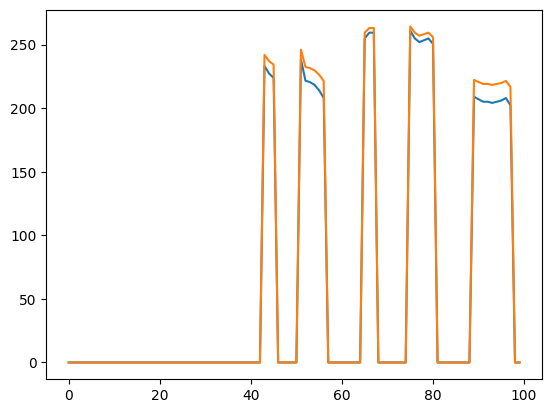

In [24]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
from  scipy.io import wavfile 

my_pqmf = pretrained.pqmf
my_encoder = pretrained.encoder
my_frame_synth = pretrained.frame_synth
my_speaker_encoder = pretrained.speaker_encoder
my_excitation = pretrained.excitation_module
wavenet = pretrained.wavenet

emb_audio, _ = librosa.load("../vctk-small/p228/p228_005_mic1.flac", sr=44100, mono=True)
emb_audio = torch.tensor(emb_audio[:131072]).unsqueeze(0)
emb_audio_pqmf = my_pqmf(torch.tensor(emb_audio.unsqueeze(1)))
target_emb = my_speaker_encoder(emb_audio_pqmf).unsqueeze(2)

x, _ = librosa.load("libri.wav", sr=44100, mono=True)
x = torch.tensor(x[:2*131072]).unsqueeze(0)

x_multi = my_pqmf(x.unsqueeze(1))

z = my_encoder(x_multi[:, :6, :])
emb = target_emb.repeat(z.shape[0], 1, z.shape[-1])

print(z.shape, emb.shape)
        
#z = torch.cat((z, emb), dim=1)
frames = my_frame_synth(z, emb)

pitch_inp = get_pitch(x, 1024)
pitch_tar = get_pitch(emb_audio, 1024)

plt.plot(pitch_inp[0, :100])
        
pitch_stat = pitch_inp
pitch_stat[pitch_stat == 0] = float('nan')
pitch_stat = pitch_stat[~torch.isnan(pitch_stat)]
mean_inp = torch.mean(pitch_stat)
std_inp = torch.std(pitch_stat)

pitch_stat = pitch_tar
pitch_stat[pitch_stat == 0] = float('nan')
pitch_stat = pitch_stat[~torch.isnan(pitch_stat)]
mean_tar = torch.mean(pitch_stat)
std_tar = torch.std(pitch_stat)

standardized_source_pitch = (pitch_inp - mean_inp) / std_inp
source_pitch = (standardized_source_pitch * std_tar + mean_tar)
source_pitch[torch.isnan(source_pitch)] = 0

plt.plot(source_pitch[0, :100])
ex = my_excitation(x, source_pitch.unsqueeze(-1))

#plt.plot(source_pitch)

#ex = my_excitation(x, 1.0)
#ipd.display(ipd.Audio(ex[0].numpy(), rate=44100))
ipd.display(ipd.Audio(ex[0].numpy(), rate=44100))
#y_multiband = my_decoder(z)

interp = torch.nn.functional.interpolate(
            frames, size=ex.shape[-1], mode="linear"
        )

y = wavenet(ex, interp)

ipd.display(ipd.Audio(y[0].numpy(), rate=44100))

  [INFO]: device is not None, use cuda:0
  [INFO]    > call by:torchfcpe.tools.spawn_infer_cf_naive_mel_pe_from_pt
  [WARN] args.model.use_harmonic_emb is None; use default False
  [WARN]    > call by:torchfcpe.tools.spawn_cf_naive_mel_pe
torch.Size([1, 257, 1]) torch.Size([256])


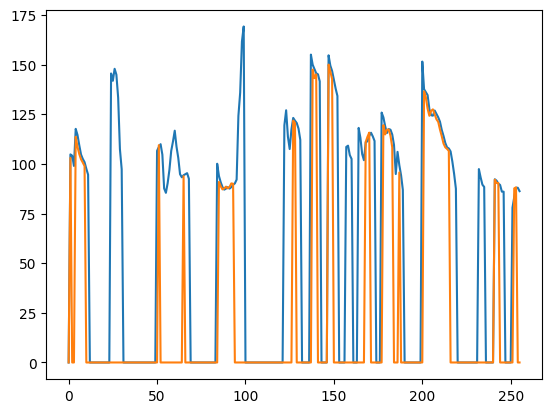

In [48]:
from torchfcpe import spawn_bundled_infer_model
import torch
import librosa
import torchyin

# configure device and target hop_size
device = 'cuda:0'
sr = 44100
hop_size = 1024

# load audio
audio, sr = librosa.load("libri.wav", sr=sr, mono=True)
audio = audio[:2*131072]
audio_length = len(audio)
f0_target_length=(audio_length // hop_size) + 1
audio_t = torch.from_numpy(audio).float().unsqueeze(0).unsqueeze(-1).to(device)

# load model
model = spawn_bundled_infer_model(device=device)

# infer
'''
audio: wav, torch.Tensor
sr: sample rate
decoder_mode: [Optional] 'local_argmax' is recommended
threshold: [Optional] threshold for V/UV decision, 0.006 is recommended
f0_min: [Optional] minimum f0
f0_max: [Optional] maximum f0
interp_uv: [Optional] whether to interpolate unvoiced frames
output_interp_target_length: [Optional] If not None, the output f0 will be
    interpolated to the target length
'''
f0 = model.infer(
    audio_t,
    sr=sr,
    decoder_mode='local_argmax',
    threshold=0.006,
    f0_min=50,
    f0_max=500,
    interp_uv=False,
    output_interp_target_length=f0_target_length,
)


desired_num_frames = torch.tensor(audio).shape[-1] / 1024
tau_max = int(sr / 50)
frame_length = 2 * tau_max
frame_stride = (torch.tensor(audio).shape[-1] - frame_length) / (desired_num_frames - 1) / sr
f0_yin = torchyin.estimate(torch.tensor(audio), sample_rate=sr, pitch_min=50, pitch_max=500, frame_stride=frame_stride)

print(f0.shape, f0_yin.shape)
plt.plot(f0[0, :256, 0].cpu().numpy())
plt.plot(f0_yin.numpy())

# the model is son class of torch.nn.Module, so you can use it as a normal pytorch model
# example: change device
model = model.to(device)
# example: compile model
model = torch.compile(model)